This is a script that is almost a carbon copy of the "plot single ODMR" notebook. 

The difference between the two is that this script allows for the plotting of 3 ODMR peaks, as have been observed in some of my experiments.I can't imaging this script will be used particularly often as this is not a phenomina that I expect to excounter a lot. I have made this script purely to identify properly the three peaks that are observed and to see if the resonant frequencies or curve-shapes can reveal where this mysterious third peak has come from. 

In [1]:
import numpy as np 
import scipy.optimize as opt
import matplotlib.pyplot as plot
import os

In [2]:
def load_data(file_ID, date):
    # Create folder and file name
    folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\'
    
    file_name = folder_path + date + '\\' + file_ID 
    print(file_name)
    # Load data from file and perfrom a mean of the value. 
    data = np.loadtxt(file_name + '.dat')
    
    mean_data = np.mean(data, axis=0)
    # load data from params file. 
    params_file = folder_path + date + '\\'  + file_ID + 'Params' + '.dat'
    params = np.loadtxt(params_file, delimiter = '\t', usecols = 1)
    start = params[0]
    stop = params[1]
#    step = params[2]*0.001
    no_of_steps = len(mean_data)
   
    # Creates a variable containing the applied frequencies. 
    if start < stop:
        freq = np.linspace(start, stop, no_of_steps)
    else:
        freq = np.linspace(stop, start, no_of_steps)
        mean_data = mean_data[::-1]
        
    #mean_data = mean_data/(np.max(mean_data))
        
    return(freq, mean_data, data)   

In [3]:
def scatter_plot(freq,mean_data):
    # Creates a scatter plot for experimental data and plot parameters. 
    fig, ax = plot.subplots()
    plot.rcParams.update({'font.size' : 16})
    plot.rcParams.update({'figure.figsize' :[12, 8]})
    ax.scatter(freq, mean_data, marker = 'x',color = 'r', label = "Experiment Data")
    
    return(fig, ax)

In [11]:
def Analysis(freq, mean_data):    
    end_point = int(len(mean_data))
    #   Determines the mean fluorescenet baseline signal. 
    fluor_baseline = np.mean(mean_data[int(np.floor(0.9*end_point)):end_point])
    fluor_min = np.min(mean_data)

    # First guesses for the curve fittings
    A = (fluor_min-fluor_baseline)
    x0 = 2.83
    gamma = 0.01
    offset = fluor_baseline
    A2 = (fluor_min-fluor_baseline)
    x02 = 2.85
    gamma2 = 0.01
    A3 = (fluor_min-fluor_baseline)
    x03 = 2.88
    gamma3 = 0.01
    
    P2 = [A, x0, gamma, A2, x02, gamma2, A3, x03, gamma3, offset]
    P2 = np.array(P2)
    
    analysis = multi_peak(freq, mean_data, P2)
    return(analysis)

In [12]:
def multi_peak(freq, mean_data, P2):
    # Apply curve fitting optimisation 
    coeffs, confidence = opt.curve_fit(lorentz_3, freq, mean_data, P2)
    opt_error = np.sqrt(np.diag(confidence))
    
    x = freq 
    
    y = lorentz_3(x, coeffs[0], coeffs[1], coeffs[2], coeffs[3], coeffs[4], coeffs[5], coeffs[6], 
                  coeffs[7], coeffs[8], coeffs[9])
    
    contrast = (1-(np.min(mean_data)/coeffs[9]))*100
    contrast_error = (np.sqrt(coeffs[9])/coeffs[9])*contrast
    print('contrast; ' + str(contrast))
    return([x, y, coeffs, opt_error, contrast, contrast_error])

In [13]:
def plot_fitting(ax, x, y):    
    #Plot  fit and complete graph
    plot.plot(x,y, color = 'k', linewidth = 2.0, label = "Double Lorentzian curve fitting")
    ax.set_xlabel('Microwave Frequency  (GHz)')
    ax.set_ylabel('Counts (per int. time)')
    #axes = plot.gca()
    ax.set_xlim(np.min(x), np.max(x))
#    axes.set_ylim(0.985*np.min(y), 1.02*np.max(y))
    ax.legend(loc = 'lower right')
    return(ax)

In [15]:
def get_r_squared(x, y_data, y_fitting):
    # This is a function used to generate the goodness of fit metric r^2.
    # This value will be used to judge the effectiveness of the curve fitting 
    # used to find the resonant frequencies of the NV centre.
    
    y_data_mean = np.mean(y_data)
    SStot = np.sum((y_data - y_data_mean)**2) # Find the variation in experimental y values.
    SSres = np.sum((y_data - y_fitting)**2) # Find the variation betweem the experimental and fitted y values. 
    
    r_squared = 1 - (SSres/SStot) # Calculate R^2
    
    return(r_squared)

In [16]:
def save_data(date, file_ID, contrast, contrast_error, coeffs, opt_error, r_squared):
    
    destination_folder = 'H:\\My Documents\\Strathclyde_Back_up\\Graphs_and_analysis\\ODMR\\' + date + '\\'
    output_data_file = destination_folder + date + '_NVScan_analysis.dat'
    # Checking to see if the folder exists in which to save the data, and creating it if it does not
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        # Checking the output file exists and creating and initialising it if not
    if os.path.isfile(output_data_file) == False:
        with open(output_data_file, "w") as wf:
            wf.write('File name' +  ', \t' + 'Max Contrast (%)' + '\t' + 'Contrast error (%)' + '\t' + 
                     'Resonant frequency 1 (GHz)' + '\t' + 'Error Resonant frequency 1 (GHz)' + '\t' + 
                     'FWHM 1 (MHz)' + '\t' + 'FWHM 1 error (MHz)' + '\t' + 
                     'Resonant frequency 2 (GHz)' + '\t' + 'Error Resonant frequency 2 (GHz)' + '\t' + 
                     'FWHM 2 (MHz)' + '\t' + 'FWHM 2 error (MHz)' + '\t' + 
                     'Resonant frequency 3 (GHz)' + '\t' + 'Error Resonant frequency 3 (GHz)' + '\t' + 
                     'FWHM 3 (MHz)' + '\t' + 'FWHM 3 error (MHz)' + '\t' + 
                     'Off Res Fluorescence intensity (per dwell time)' + '\t' +'R^2 for fitting' +'\n')
    # Writing contrast dip description to the .dat file
    
    with open(output_data_file, "a") as wf:
        wf.write(file_ID + ' \t' +  str(contrast) + " \t"  + str(contrast_error) +
                 " \t"  + str(coeffs[1]) + " \t"  + str(opt_error[1]) +
                 " \t" +  str(coeffs[2]*1000) + " \t" + str(opt_error[2]*1000) + 
                 " \t"  + str(coeffs[4]) + " \t"  + str(opt_error[4]) + " \t" + 
                 str(coeffs[5]*1000) + " \t" + str(opt_error[5]*1000) + " \t" + 
                 str(coeffs[7]) + " \t"  + str(opt_error[7]) + " \t" + 
                 str(coeffs[8]*1000) + " \t" + str(opt_error[8]*1000) + " \t" +
                 str(coeffs[9]) + " \t" +str(r_squared) + '\n')
    # Saving a plot of the raw data to a folder. 
    plot.savefig(destination_folder + file_ID + '.pdf', transparent = True)    
    plot.savefig(destination_folder + file_ID + '.png', transparent = True) 
  
  

I:\Science\Physics-Nanobiophotonics\Group\User Data\ODMR\ODMR and imaging\20201106\20201106_NVScan_01
contrast; 16.69698787003743
R^2 = 0.9092610312071305


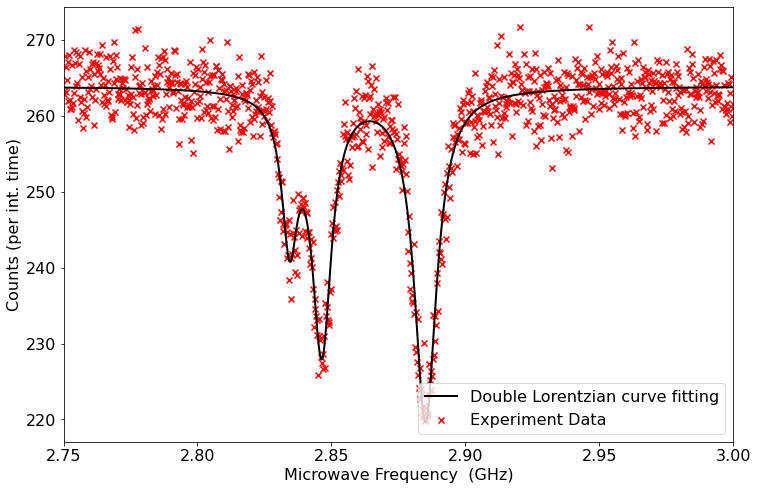

In [17]:
date = '20201106'
fileID = date + '_NVScan' + '_01'
freq, mean_data, data = load_data(fileID, date)
fig, ax = scatter_plot(freq, mean_data)
analysis = Analysis(freq, mean_data)
plot_fitting(ax, analysis[0], analysis[1])
r_squared = get_r_squared(freq, mean_data, analysis[1])
print('R^2 = ' + str(r_squared))
#save_data(date, fileID, analysis[4], analysis[5], analysis[2], analysis[3], r_squared)  

In [11]:
print(analysis[5])

0.2980169784006872
